
# Investigation A — Do bats perceive rats as predators?
**HIT140 — Foundations of Data Science (Assessment 2)**

What we are doing here is:
- Load and inspect `dataset1.csv` and `dataset2.csv`
- Data cleaning and feature engineering
- Descriptive analysis and plots
- Inferential tests (Chi-square, Mann-Whitney U)



In [25]:

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import os

pd.options.display.max_columns = 200


In [26]:

# Load datasets
d1 = pd.read_csv("dataset1.csv")
d2 = pd.read_csv("dataset2.csv")

print("Dataset1 shape:", d1.shape)
print("Dataset2 shape:", d2.shape)

d1.head()


Dataset1 shape: (907, 12)
Dataset2 shape: (2123, 7)


start_time  bat_landing_to_food habit  rat_period_start  \
0  30/12/2017 18:37            16.000000   rat  30/12/2017 18:35   
1  30/12/2017 19:51             0.074016  fast  30/12/2017 19:50   
2  30/12/2017 19:51             4.000000  fast  30/12/2017 19:50   
3  30/12/2017 19:52            10.000000   rat  30/12/2017 19:50   
4  30/12/2017 19:54            15.000000   rat  30/12/2017 19:50   

     rat_period_end  seconds_after_rat_arrival  risk  reward  month  \
0  30/12/2017 18:38                        108     1       0      0   
1  30/12/2017 19:55                         17     0       1      0   
2  30/12/2017 19:55                         41     0       1      0   
3  30/12/2017 19:55                        111     1       0      0   
4  30/12/2017 19:55                        194     1       0      0   

        sunset_time  hours_after_sunset  season  
0  30/12/2017 16:45            1.870833       0  
1  30/12/2017 16:45            3.100833       0  
2  30/12/2017 16:45            3.107500       0  
3  30/12/2017 16:45            3.126944       0  
4  30/12/2017 16:45            3.150000       0

In [27]:
# Parse datetime columns with explicit format
def parse_datetime(series):
    # Use the exact format of your dates to avoid warnings
    return pd.to_datetime(series, errors='coerce', format='%d/%m/%Y %H:%M')

# Apply to columns in d1
for col in ['start_time', 'rat_period_start', 'rat_period_end', 'sunset_time']:
    if col in d1.columns:
        d1[col] = parse_datetime(d1[col])

# Apply to 'time' column in d2
if 'time' in d2.columns:
    d2['time'] = parse_datetime(d2['time'])


In [28]:

# Convert some columns to categorical
for col in ['month','season','habit']:
    if col in d1.columns:
        d1[col] = d1[col].astype('category')
if 'month' in d2.columns:
    d2['month'] = d2['month'].astype('category')

d1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   start_time                 907 non-null    datetime64[ns]
 1   bat_landing_to_food        907 non-null    float64       
 2   habit                      866 non-null    category      
 3   rat_period_start           907 non-null    datetime64[ns]
 4   rat_period_end             907 non-null    datetime64[ns]
 5   seconds_after_rat_arrival  907 non-null    int64         
 6   risk                       907 non-null    int64         
 7   reward                     907 non-null    int64         
 8   month                      907 non-null    category      
 9   sunset_time                907 non-null    datetime64[ns]
 10  hours_after_sunset         907 non-null    float64       
 11  season                     907 non-null    category      
dtypes: categ

In [29]:

# Feature engineering: rat presence at landing
if {'start_time','rat_period_start','rat_period_end'}.issubset(d1.columns):
    d1['rat_present_at_landing'] = (
        (d1['start_time'] >= d1['rat_period_start']) &
        (d1['start_time'] <= d1['rat_period_end'])
    ).astype(int)
elif 'seconds_after_rat_arrival' in d1.columns:
    d1['rat_present_at_landing'] = (d1['seconds_after_rat_arrival'] >= 0).astype(int)
else:
    d1['rat_present_at_landing'] = 0

d1['rat_present_at_landing'].value_counts()


rat_present_at_landing
1    907
Name: count, dtype: int64

In [30]:

# Descriptive stats
d1[['bat_landing_to_food','seconds_after_rat_arrival','hours_after_sunset']].describe()


bat_landing_to_food  seconds_after_rat_arrival  hours_after_sunset
count           907.000000                 907.000000          907.000000
mean             11.713134                 282.877619            5.531863
std              27.644410                 240.974918            2.414146
min               0.010238                   0.000000           -0.261667
25%               1.000000                  89.500000            3.779028
50%               4.000000                 206.000000            5.622778
75%              11.500000                 446.500000            7.402778
max             443.000000                 949.000000           12.091944

In [31]:

# Risk and reward counts
if 'risk' in d1.columns:
    print(d1['risk'].value_counts())

if 'reward' in d1.columns:
    print(d1['reward'].value_counts())


risk
0    458
1    449
Name: count, dtype: int64
reward
1    484
0    423
Name: count, dtype: int64


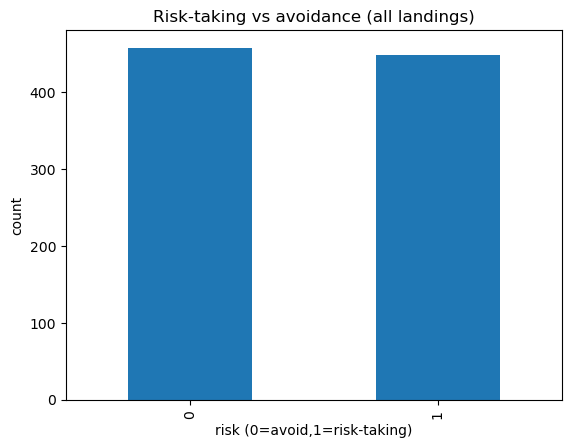

In [32]:

# Risk overall plot
if 'risk' in d1.columns:
    d1['risk'].value_counts().sort_index().plot(kind='bar')
    plt.title("Risk-taking vs avoidance (all landings)")
    plt.xlabel("risk (0=avoid,1=risk-taking)")
    plt.ylabel("count")
    plt.show()


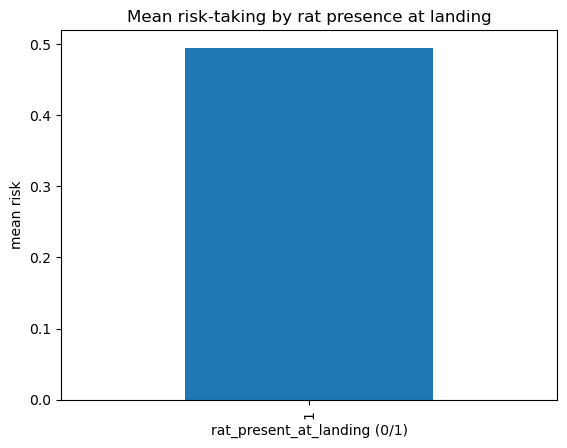

In [33]:

# Risk by rat presence
if 'risk' in d1.columns and 'rat_present_at_landing' in d1.columns:
    pivot = d1.pivot_table(index='rat_present_at_landing', values='risk', aggfunc='mean')
    pivot.plot(kind='bar', legend=False)
    plt.title("Mean risk-taking by rat presence at landing")
    plt.xlabel("rat_present_at_landing (0/1)")
    plt.ylabel("mean risk")
    plt.show()


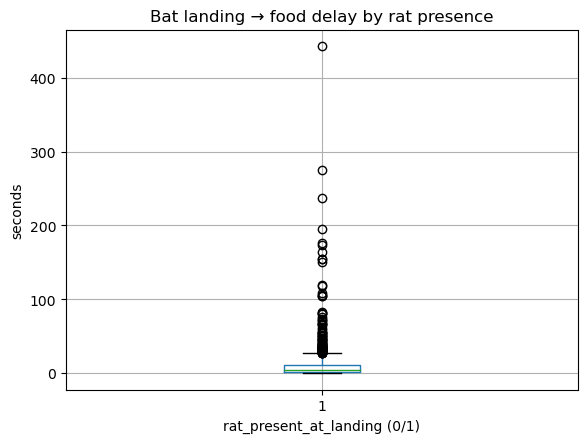

In [34]:

# Hesitation boxplot
if 'bat_landing_to_food' in d1.columns and 'rat_present_at_landing' in d1.columns:
    d1.boxplot(column='bat_landing_to_food', by='rat_present_at_landing')
    plt.title("Bat landing → food delay by rat presence")
    plt.suptitle("")
    plt.xlabel("rat_present_at_landing (0/1)")
    plt.ylabel("seconds")
    plt.show()


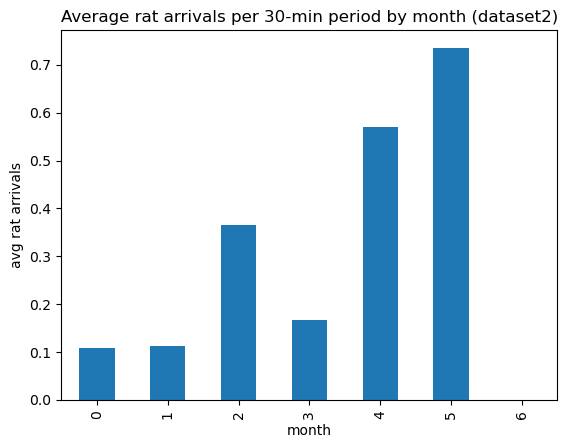

In [35]:
# Rat arrivals by month (dataset2)
if 'rat_arrival_number' in d2.columns and 'month' in d2.columns:
    d2.groupby('month', observed=False)['rat_arrival_number'].mean().plot(kind='bar')
    plt.title("Average rat arrivals per 30-min period by month (dataset2)")
    plt.xlabel("month")
    plt.ylabel("avg rat arrivals")
    plt.show()


In [36]:

# Inferential tests

# Chi-square: rat presence vs risk
if 'risk' in d1.columns and 'rat_present_at_landing' in d1.columns:
    ct = pd.crosstab(d1['rat_present_at_landing'], d1['risk'])
    print("Contingency table:\n", ct)
    if ct.shape == (2,2):
        chi2, p, dof, exp = stats.chi2_contingency(ct)
        print(f"Chi-square: chi2={chi2:.3f}, dof={dof}, p={p:.4g}")

# Mann-Whitney U: hesitation times
if 'bat_landing_to_food' in d1.columns and 'rat_present_at_landing' in d1.columns:
    g0 = d1.loc[d1['rat_present_at_landing']==0, 'bat_landing_to_food'].dropna()
    g1 = d1.loc[d1['rat_present_at_landing']==1, 'bat_landing_to_food'].dropna()
    if len(g0)>5 and len(g1)>5:
        u, p = stats.mannwhitneyu(g0, g1, alternative='two-sided')
        print(f"Mann-Whitney U: U={u:.1f}, p={p:.4g} (n0={len(g0)}, n1={len(g1)})")


Contingency table:
 risk                      0    1
rat_present_at_landing          
1                       458  449
